# Positional Encoding
A final ingredient for the transformer architecture is positional encoding.

With Attention we loose all sense of location in a sentence. A way around this is to add positional encoding.

The idea is to add multiple sine waves.
One sinewave will have a very fast frequency, another sinewave will have a slow frequency.
Note that this is exactly how our time-system works: minutes have a fast frequency, hours a slower one, days of the week even slower etc.

By combining a lot of sinewaves the model is able to figure out something about the location in time, relative to each other. 

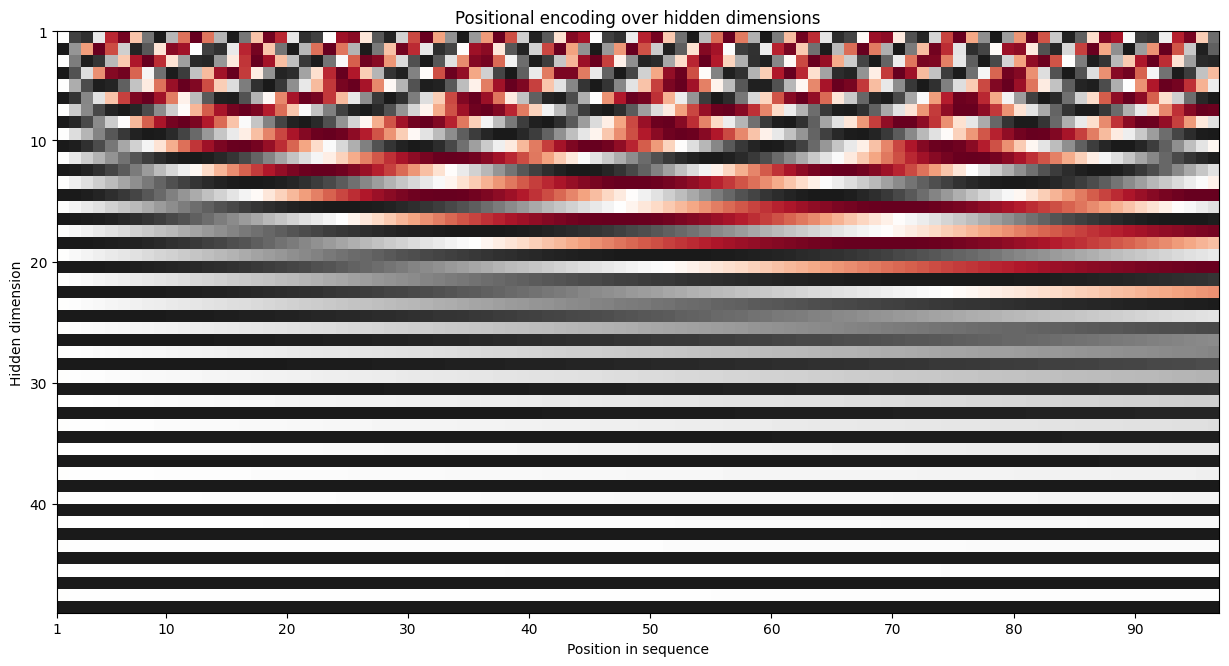

In [5]:
import matplotlib.pyplot as plt
import torch
from torch import nn, Tensor
import math

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_seq_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        position = torch.arange(max_seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_seq_len, d_model)
        # batch, seq_len, d_model
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
        """
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


encod_block = PositionalEncoding(d_model=48, dropout=0.1, max_seq_len=96)
pe = encod_block.pe.squeeze().T.cpu().numpy()

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.imshow(pe, cmap="RdGy", extent=(1, pe.shape[1] + 1, pe.shape[0] + 1, 1))
# fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1] + [i * 10 for i in range(1, 1 + pe.shape[1] // 10)])
ax.set_yticks([1] + [i * 10 for i in range(1, 1 + pe.shape[0] // 10)])
plt.show()

We can now completely recreate the transformer architecture. 

We will build the encoder-block (inside the dotted line, on the left). The encoder-decoder architecture is typically used for translation tasks. But we can use the encoder block for other tasks too, like classification or regression.


<img src=transformers.pbm width=700/>

In [6]:
class TransformerBlock(nn.Module):
    def __init__(self, hidden_size, num_heads, dropout):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_size,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True,
        )
        self.ff = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
        )
        self.layer_norm1 = nn.LayerNorm(hidden_size)
        self.layer_norm2 = nn.LayerNorm(hidden_size)

    def forward(self, x):
        identity = x.clone()
        x, _ = self.attention(x, x, x)
        x = self.layer_norm1(x + identity)
        identity = x.clone()
        x = self.ff(x)
        x = self.layer_norm2(x + identity)
        return x

class Transformer(nn.Module):
    def __init__(
        self,
        config: dict,
    ) -> None:
        super().__init__()
        self.pos_encoder = PositionalEncoding(config["hidden"], config["dropout"])

        # Create multiple transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(config["hidden"], config["num_heads"], config["dropout"])
            for _ in range(config["num_blocks"])
        ])

        self.out = nn.Linear(config["hidden"], config["output"])

    def forward(self, x: Tensor) -> Tensor:
        x = self.pos_encoder(x)

        # Apply multiple transformer blocks
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)

        x = x.mean(dim=1)
        x = self.out(x)
        return x

Lets test it:

In [10]:
# create a random torch tensor with batch size 32, sequence length 64 and 128 features
# note that the hidden dimensions of the transformer should be equal to the feature dimensions
X = torch.randn(32, 64, 128)

config = {
    "hidden": 128,
    "dropout": 0.1,
    "num_heads": 4,  # sequence length should be divisible by num_heads
    "num_blocks": 3,
    "output": 2,
}

transformer = Transformer(config)

In [11]:
output = transformer(X)
output.shape

torch.Size([32, 2])